In [31]:
import os
import cohere
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from retry import retry

co = cohere.Client()

# Prettify Graphs
np.set_printoptions(precision=3, suppress=True)
sns.set_theme(style='darkgrid', palette='pastel', font_scale=1.25)
plt.rc('xtick', labelsize=10)

In [10]:
synonym_categories = {
    'max_limit': ['at most', 'no more than', 'less than', 'maximum', 'under'],
#    'min_limit': ['at least', 'no less than', 'more than', 'minimum', 'over'],
#    'approx': ['around', 'approximately', 'about', 'roughly', 'close to'],
#    'exact': ['exactly', '', 'right at', 'strictly', 'just'],
}

In [11]:
# DEF traverse synonym categories to generate + save num_responses of each synonym for each synonym_category

def traverse_synonym_categories(synonym_categories):
    for synonym_category, synonyms in synonym_categories.items():
        for synonym in synonyms:
            user_prompt = f'What is gravity? Your explanation should be {synonym} 150 words.'
            user_prompt = user_prompt.replace('  ', ' ')
            print(user_prompt)
            save_responses(1000, user_prompt, synonym_category, synonym)

In [12]:
# DEF generate single response from user_prompt

@retry(tries=10, delay=2, backoff=2)
def generate_response(user_prompt):
    response = co.chat(
        model='command',
        message=user_prompt
    )
    return response

In [13]:
# DEF save num_responses for particular synonym with appropriate file names

def save_responses(num_responses, user_prompt, synonym_category, synonym):
    responses = []
    for _ in tqdm(range(num_responses)):
        response = generate_response(user_prompt)
        responses.append(response.text)
    df = pd.DataFrame(responses, columns=['response'])
    df['length'] = df.response.apply(lambda x: len(x.split(' ')))
    os.makedirs(f'{synonym_category}', exist_ok=True)
    df.to_csv(f'./{synonym_category}/{synonym}_{int(time.time())}.csv')
    return df

In [14]:
# Run synonyms for all synonym_categories

traverse_synonym_categories(synonym_categories)

What is gravity? Your explanation should be at most 150 words.


100%|█████████████████████████████████████| 1000/1000 [1:48:49<00:00,  6.53s/it]


What is gravity? Your explanation should be no more than 150 words.


100%|█████████████████████████████████████| 1000/1000 [1:51:59<00:00,  6.72s/it]


What is gravity? Your explanation should be less than 150 words.


100%|█████████████████████████████████████| 1000/1000 [1:54:56<00:00,  6.90s/it]


What is gravity? Your explanation should be maximum 150 words.


100%|█████████████████████████████████████| 1000/1000 [1:47:47<00:00,  6.47s/it]


What is gravity? Your explanation should be under 150 words.


100%|█████████████████████████████████████| 1000/1000 [1:49:30<00:00,  6.57s/it]


In [34]:
# histograms

def plot_histogram(df, name, ax, min_length, max_length):
    bins = range(80, 255, 5)
    n, _, patches = ax.hist(df.length, bins=bins)
    ax.set_xticks(bins)
    ax.set_xticklabels(bins, rotation=45, ha='center')
    # ax.set_xlabel('Word count')
    # ax.set_ylim(0, 12)
    ax.set_ylabel('Number of responses')
    # view correct bins
    correct_bins = np.where((np.array(bins) >= min_length) & (np.array(bins) < max_length))[0]
    correct_percentage = sum(n[i] for i in correct_bins) / len(df) * 100

    ax.set_title(f'{name}: {correct_percentage:.2f}%')
    for i in correct_bins:
        patches[i].set_facecolor('orange')

def process_files(data_dir, min_length, max_length):

    # read dataframes
    dfs = {}
    for data_file in sorted(os.listdir(data_dir)):
        df = pd.read_csv(f'./{data_dir}/{data_file}', index_col=0)
        dfs[data_file.split('_')[0]] = df

    # plot dataframes
    fig, axs = plt.subplots(nrows=len(dfs), ncols=1, figsize=(12,4*len(dfs)))
    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = .5
    plt.rcParams['xtick.bottom'] = True
    for name, ax in zip(dfs, axs):
        plot_histogram(dfs[name], name, ax, min_length, max_length)

    plt.tight_layout()
    plt.savefig(f'./Figures/{data_dir}.png', dpi=150)
    plt.show()
    return dfs

## What is gravity? Your explanation should be ____ 150 words.

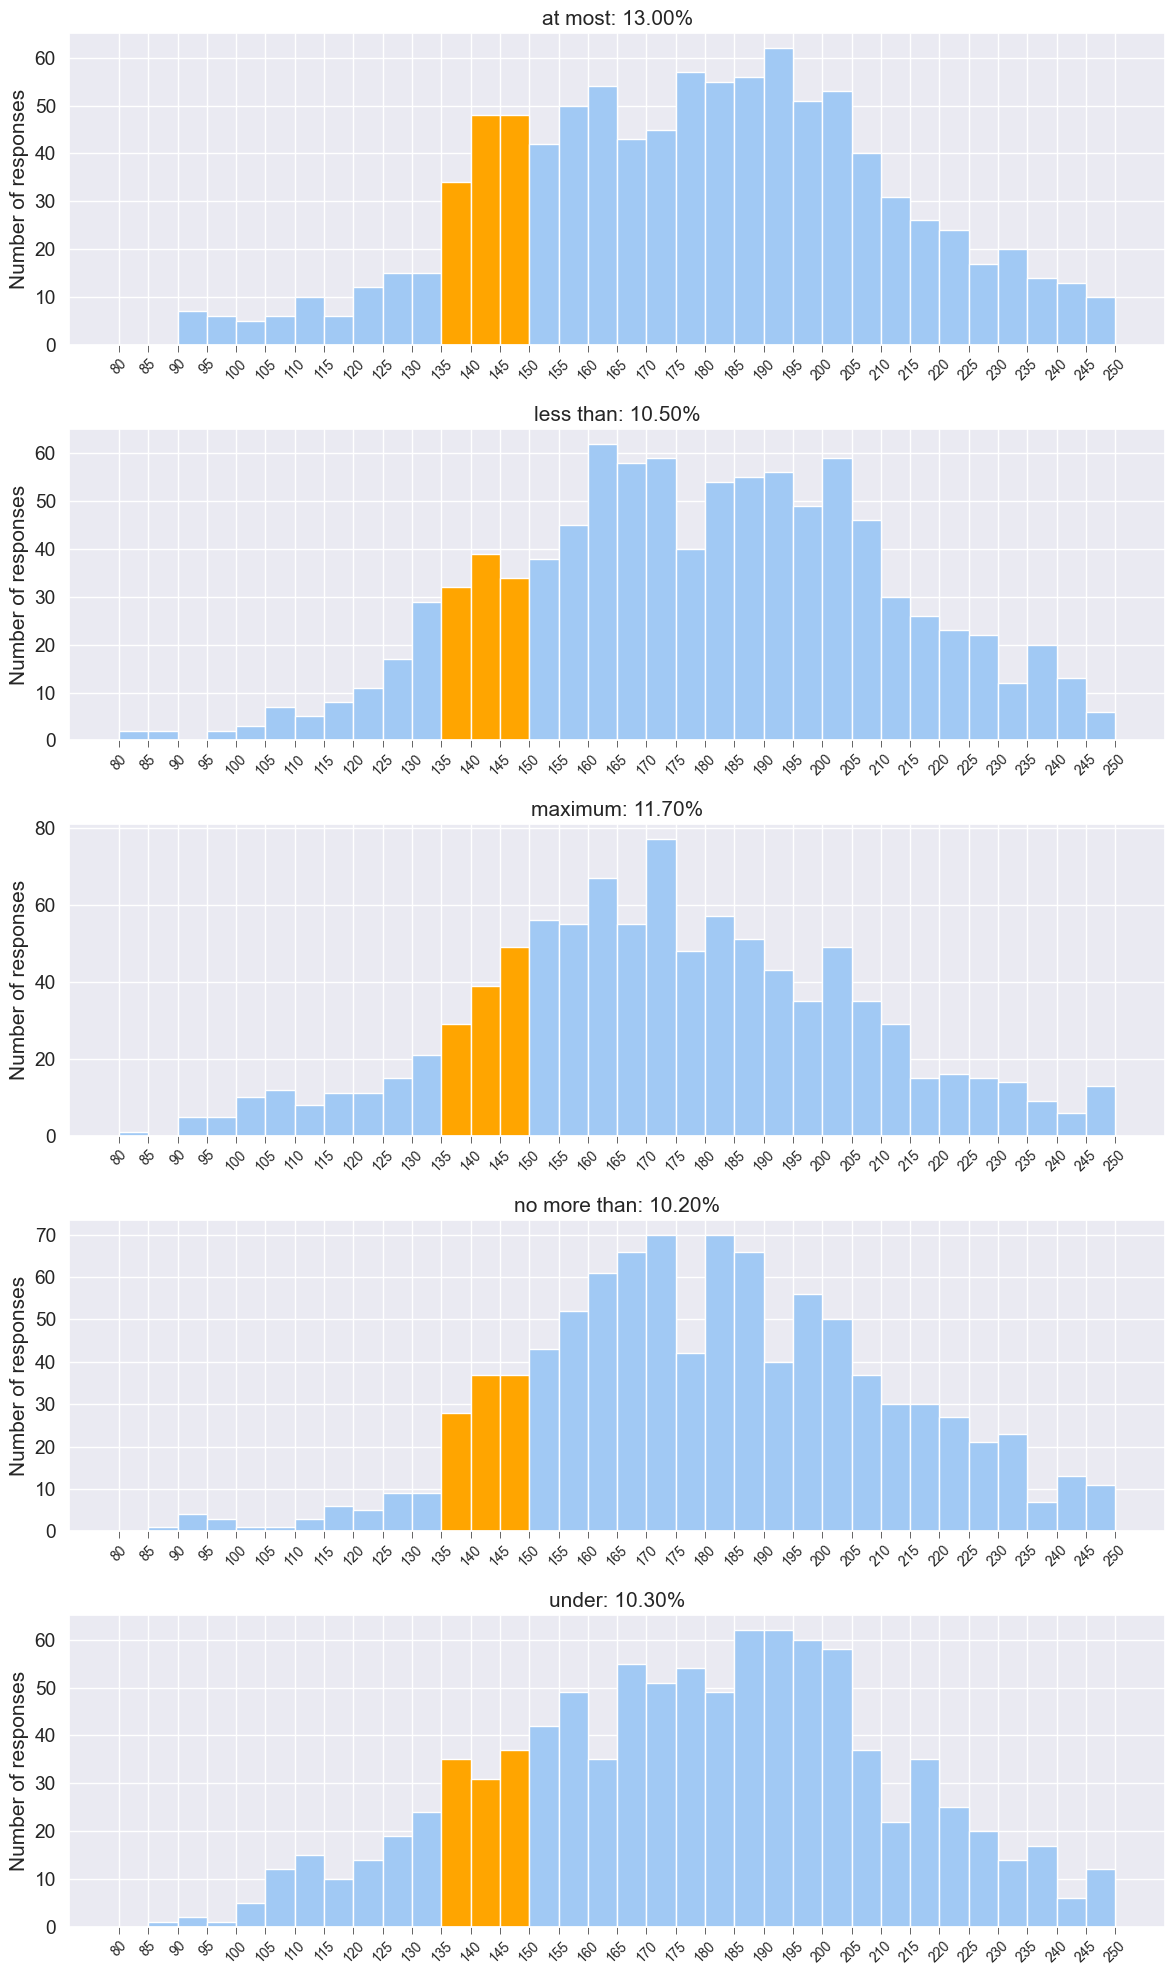

In [36]:
# max_limit

dfs = process_files('max_limit', min_length=135, max_length=150)